# Building

## Electricity demand analysis

Throughout this document hierarchical forecasting will be used as seen in [Forecasting: Principles and Practice](https://otexts.com/fpp2/hts.html) for analysing electricity demand of a whole building. The structure is a K-1 level architecture with m=3 series at the bottom level and n=4 total number of series in the hierarchy. For a more detailed analysis of first and third floor data see [first floor electricity demand](./ed_first_floor.ipynb) and [third floor electricity demand](./ed_first_floor.ipynb) .

## Overview
The following tables contain the MAPE of the forecasts of the cumulative serie, the one that is obtained by summing first, second and third floor electricity demand, given three different hierarchical approaches on hourly and daily data.

### Daily data

| Approach               | MAPE |
|------------------------|------|
| Optimal Reconciliation |  2.7 |
| Top Down               |  2.8 |
| Bottom Up              |  3.4 |

- Optimal Reconciliation: it is usually one of the most accurate approaches, it is the only one among those in the table that is guaranteed to give unbiased results;
- Top Down: can beat optimal reconciliation as it takes into account the way every series change in time and how much it weights on the top level that is the one from wich the forecast is propagated, in this case they are very close;
- Bottom Up: it work well because an ARIMA model is used for forecasting the bottom level, which we [already saw](./ed_first_floor.ipynb) working really well for forecasting those series, and then it is propagated for just one layer so not much information is lost or distorded climbing the hierarchy.


### Hourly Data

| Approach               | MAPE |
|------------------------|------|
| Bottom Up              |  5.0 |
| Top Down               |  6.0 |
| Optimal Reconciliation |  6.7 |

- Bottom Up: it works better than the others because looking at this table and at the series, from the plots that follow for example, one can guess that a hierarchical approach is not going to be very advantageous;
- Top Down: the top series retains much of the seasonality of the first two floors and so the forecast is reasonably accurate
- Optimal Reconciliation: this the model that best employs hierarchical realtions but in this case they are not relevant enough to give good accuracy, if demands per apartment instead of demands per floor where given maybe  this method would have outperformed all the others.



## Installing required packages

In [2]:
install.packages("hts")
install.packages("gridExtra")

Installing package into ‘/home/dpaletti/R/x86_64-pc-linux-gnu-library/4.0’
(as ‘lib’ is unspecified)

also installing the dependencies ‘farver’, ‘labeling’, ‘munsell’, ‘R6’, ‘RColorBrewer’, ‘viridisLite’, ‘pkgconfig’, ‘xts’, ‘TTR’, ‘curl’, ‘gtable’, ‘isoband’, ‘scales’, ‘tibble’, ‘withr’, ‘quadprog’, ‘quantmod’, ‘colorspace’, ‘fracdiff’, ‘ggplot2’, ‘lmtest’, ‘magrittr’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’, ‘forecast’, ‘SparseM’, ‘matrixcalc’, ‘Rcpp’, ‘RcppEigen’




## Parsing

In [5]:
library(hts)        # hierarchical time series
library(forecast)   # required package
library(ggplot2)    # graphics
library(gridExtra)  # grid arrangement in plots
library(forecast)   # Hyndman package for time series analysis

In [8]:
#csv file parsing

#first floor
hourly.first <- read.csv(file = "./data/ed_hourly_first.csv", as.is=TRUE, sep=";", header= TRUE)
daily.first <- read.csv(file="./data/ed_daily_first.csv", as.is=TRUE, sep=";", header=TRUE)

#second floor
hourly.second <- read.csv(file = "./data/ed_hourly_second.csv", as.is=TRUE, sep=";", header= TRUE)
daily.second <- read.csv(file="./data/ed_daily_second.csv", as.is=TRUE, sep=";", header=TRUE)

#third floor
hourly.third <- read.csv(file = "./data/ed_hourly_third.csv", as.is=TRUE, sep=";", header= TRUE)
daily.third <- read.csv(file="./data/ed_daily_third.csv", as.is=TRUE, sep=";", header=TRUE)

In [9]:
#date format definition

#first floor
hourly.first$date <- as.Date(hourly.first$date, format="%d/%m/%Y-%H")
daily.first$date <- as.Date(daily.first$date, format="%d/%m/%Y")

#second floor
hourly.second$date <- as.Date(hourly.second$date, format="%d/%m/%Y-%H")
daily.second$date <- as.Date(daily.second$date, format="%d/%m/%Y")

#third floor
hourly.third$date <- as.Date(hourly.third$date, format="%d/%m/%Y-%H")
daily.third$date <- as.Date(daily.third$date, format="%d/%m/%Y")

In [11]:
#time series definition

#first floor
daily.first.ts <- ts(daily.first$ed, frequency=7)
hourly.first.ts <- ts(hourly.first$ed, frequency=24)

daily.first.train <- window(daily.first.ts, end=c(102, 5))
daily.first.test <- window(daily.first.ts, start=c(102, 6))
hourly.first.train <- window(hourly.first.ts, end=c(27, 22))
hourly.first.test <- window(hourly.first.ts, start=c(27, 23))


#second floor
daily.second.ts <- ts(daily.second$ed, frequency=7)
hourly.second.ts <- ts(hourly.second$ed, frequency=24)

daily.second.train <- window(daily.second.ts, end=c(102, 5))
daily.second.test <- window(daily.second.ts, start=c(102, 6))
hourly.second.train <- window(hourly.second.ts, end=c(27, 22))
hourly.second.test <- window(hourly.second.ts, start=c(27, 23))

#third floor
daily.third.ts <- ts(daily.third$ed, frequency=7)
hourly.third.ts <- ts(hourly.third$ed, frequency=24)

daily.third.train <- window(daily.third.ts, end=c(102, 5))
daily.third.test <- window(daily.third.ts, start=c(102, 6))
hourly.third.train <- window(hourly.third.ts, end=c(27, 22))
hourly.third.test <- window(hourly.third.ts, start=c(27, 23))



In [12]:
#time series matrix

#daily
daily.train.matrix <- cbind(Building1st= daily.first.train,
                            Building2nd= daily.second.train,
                            Building3rd= daily.third.train)
daily.test.matrix <- cbind(Building1st= daily.first.test,
                           Building2nd= daily.second.test,
                           Building3rd= daily.third.test)

#hourly
hourly.train.matrix <- cbind(Building1st= hourly.first.train,
                             Building2nd= hourly.second.train,
                             Building3rd= hourly.third.train)
hourly.test.matrix <- cbind(Building1st= hourly.first.test,
                            Building2nd= hourly.second.test,
                            Building3rd= hourly.third.test)

## Plotting

For plotting and forecasting hierarchical time series the hts object is used. It needs a ts matrix and some rules to create the hierarchy.

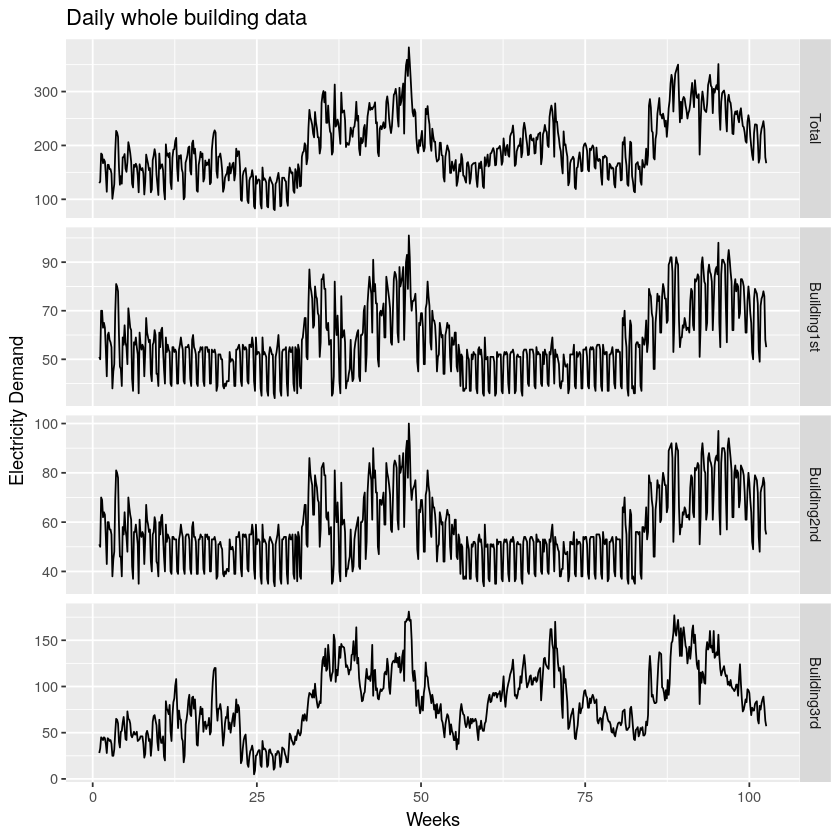

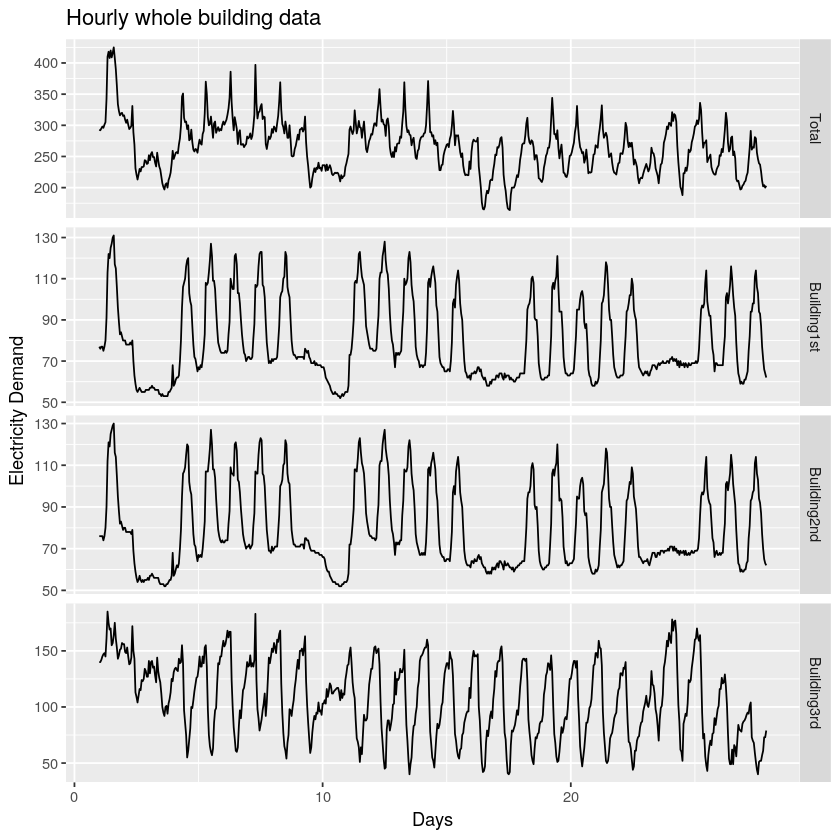

In [14]:
#plotting

#daily
daily.train <- gts(daily.train.matrix, characters = c(8, 3))
daily.test <- gts(daily.test.matrix, characters = c(8, 3))
daily.test.agg <- aggts(daily.test)
daily.train.agg <- aggts(daily.train)
autoplot(daily.train.agg, facet=TRUE) +
    ggtitle("Daily whole building data") +
    xlab("Weeks") +
    ylab("Electricity Demand")

#hourly
hourly.train <- gts(hourly.train.matrix, characters = c(8, 3))
hourly.test <- gts(hourly.test.matrix, characters = c(8, 3))
hourly.test.agg <- aggts(hourly.test)
hourly.train.agg<- aggts(hourly.train)
autoplot(hourly.train.agg, facet=TRUE) +
    ggtitle("Hourly whole building data") +
    xlab("Days") +
    ylab("Electricity Demand")

## Bottom-up approach
This approach involves first generating forecast for each series at the bottom level and then summing to produce forecast for all other series, this approach does not appear very useful in this case because the hierarchy is not deep enough and this method equals to a normal ARIMA calculated for the three floors and the summed up, on top of this ARIMA forecasts have already been calculated in the aformentioned notebooks. ARIMA is chosen because it showed to work well in previous analysis.

In [35]:
#daily
daily.fc.bu.arima <- forecast(daily.train, method="bu", fmethod = "arima", h=7)

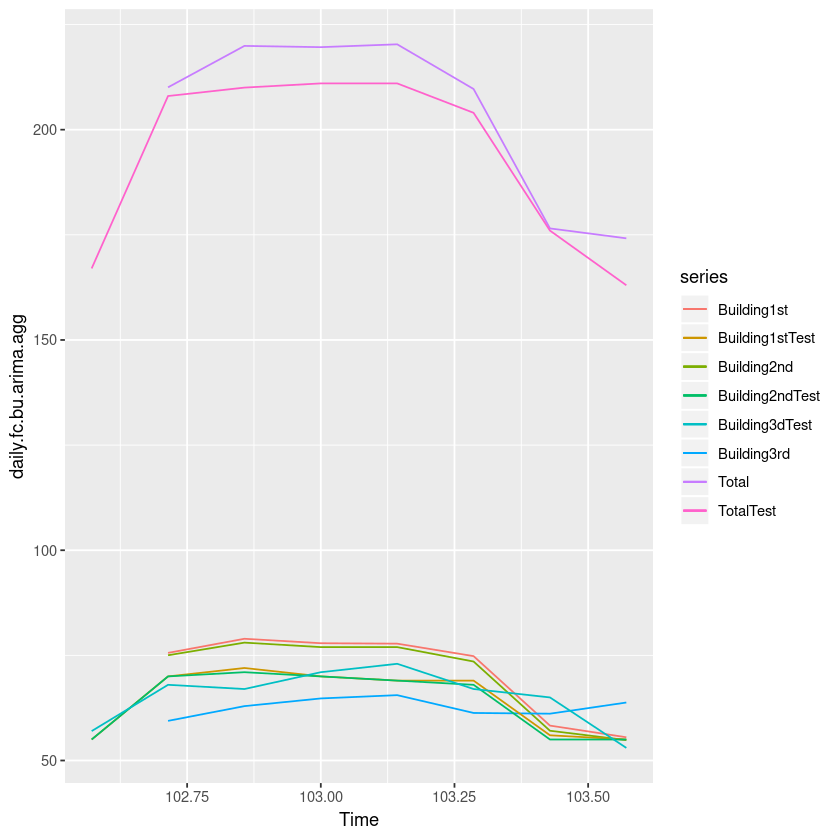

In [38]:
daily.fc.bu.arima.agg <- aggts(daily.fc.bu.arima)
autoplot(daily.fc.bu.arima.agg) +
    autolayer(daily.test.agg, series=c("TotalTest", "Building1stTest", "Building2ndTest", "Building3dTest"))

In [106]:
accuracy(daily.fc.bu.arima, daily.test)

,Total,Building1st,Building2nd,Building3rd
ME,-6.748030,-5.4099988,-4.9222586,3.584227
RMSE,7.746725,6.0773687,5.6282165,7.052824
MAE,6.748030,5.4099988,4.9669569,6.667515
MAPE,3.445940,7.8789602,7.2566725,10.352190
MPE,-3.445940,-7.8789602,-7.1754027,4.534665
MASE,0.257419,0.9089726,0.8389326,0.354896


As we can clearly see accuracy for individual floors is not very high but, in terms of MAPE, the accuracy of the whole building forecast is very good. This is because there is a lot of information for the whole building forecast as the method is bottom up so the bottom level is calculated and then the aggregation structure is used to propagate the forecast all along the hierarchy.

In [50]:
#hourly
hourly.fc.bu.arima <- forecast(hourly.train, method="bu", fmethod="arima", h=24)

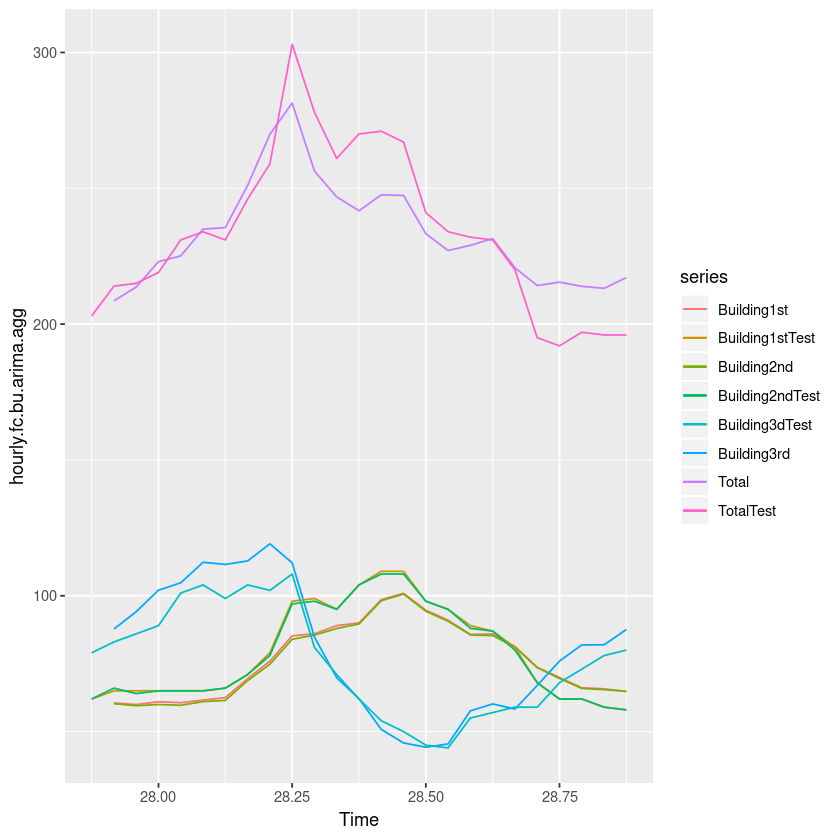

In [51]:
hourly.fc.bu.arima.agg <- aggts(hourly.fc.bu.arima)
autoplot(hourly.fc.bu.arima.agg) +
    autolayer(hourly.test.agg, series=c("TotalTest", "Building1stTest", "Building2ndTest", "Building3dTest"))

In [107]:
accuracy(hourly.fc.bu.arima, hourly.test)

,Total,Building1st,Building2nd,Building3rd
ME,1.44071112,3.0707398,3.3014357,-4.9314643
RMSE,14.69384407,6.7493695,6.8435051,7.1667211
MAE,11.81735573,5.6922067,5.9212578,5.7645767
MAPE,5.04933809,7.1011824,7.4523728,7.2017586
MPE,-0.04981141,2.8416024,3.2190864,-5.6374596
MASE,0.41732784,0.5285196,0.5517636,0.3573773


In this case, as for daily data, the accuracy for the whole building forecast is good and this probably means that a lot of information is held in the bottom level forecasts.

## Top down
This method work by forecasting the top level and then disaggregating it down the hierarchy.
The disaggregation strategy in this case must be chosen, historically disaggregation was based on proportion among the training data where the proportion is calculated as $p_j={\sum_{t=1}^{T}\frac{y_{j,t}}{T}}\Big/{\sum_{t=1}^{T}\frac{y_t}{T}}$ (Gross-Sohl method) . This approach usually produces less accurate forecast going down the hierarchy and moreover it does not take into account how the proportion may change over time so another approach is used that calculates the proportion given the one-step forecast of each series $p_j=\prod^{K-1}_{\ell=0}\frac{\hat{y}_{j,h}^{(\ell)}}{\hat{S}_{j,h}^{(\ell+1)}}$ for $j$ in $[1, m]$ where $\hat{y}_{j,h}^{(\ell)}$ is the h-step ahead initial forecast of the series that corresponds to the node which is $l$ levels above $j$ and $\hat{S}_{j,h}^{(\ell)}$ is the sum of the h-step-ahead initial forecasts below the node that is $l$ levels above node $j$ and are directly connected to that node.
The more modern and generally regarded more accurate approach is the forecast proportions approach, the second one, but due to the [way](https://stackoverflow.com/questions/36682560/error-when-using-forecast-hts-method-tdfp) the forecast function expects its hierarchy to be done some restructuring is needed. An "artificial" grouping is created, the two similar series that come from automated systems are grouped together in an Autom(ated) group while the other one is put in a Human group doing so we group similar series together. Then we use the hts object instead of the gts because the forecast function needs to have for granted that the grouping is strictly hierarchical. In the end by doing those minor changes we overcome the previously cited issue of common strings in the nodes name that makes the forecast function fail with the method set to tdfp, the one we chose.

In [262]:
#daily
daily.train.matrix.h <- cbind(Autom1st= daily.first.train,
                              Autom2nd= daily.second.train,
                              Human3rd= daily.third.train)
daily.test.matrix.h <- cbind(Autom1st= daily.first.test,
                             Autom2nd= daily.second.test,
                             Human3rd= daily.third.test)

daily.train.h <- hts(daily.train.matrix.h, characters = c(5, 3))
daily.test.h <- hts(daily.test.matrix.h, characters = c(5, 3))

daily.test.h.agg <- aggts(daily.test.h)

In [266]:
#daily
daily.fc.td <- forecast(daily.train.h, method="tdfp", h=7)

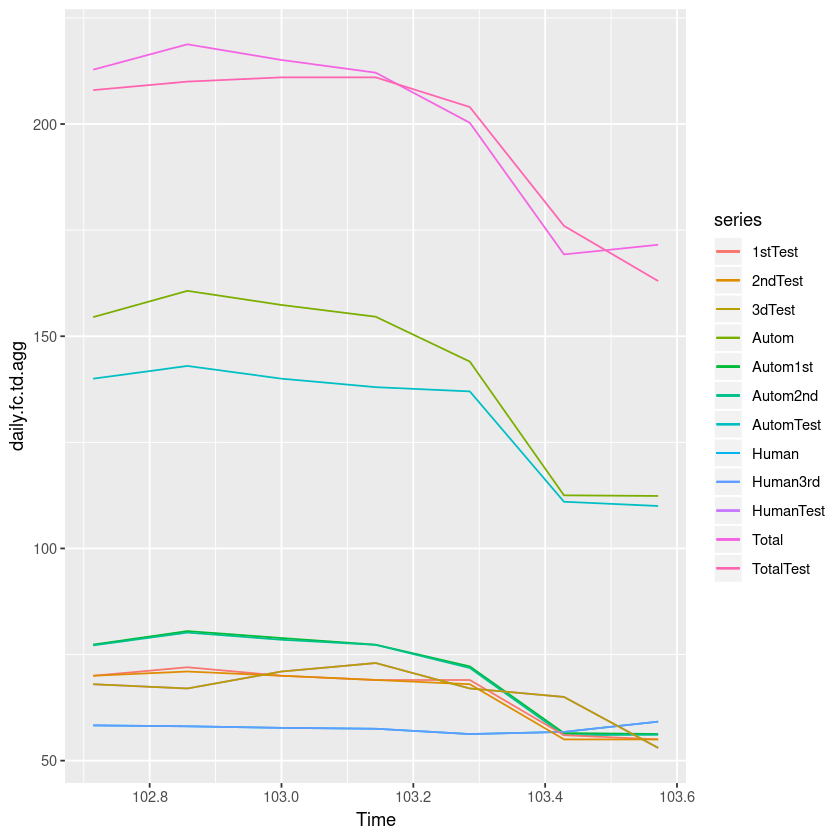

In [267]:
daily.fc.td.agg <- aggts(daily.fc.td)
autoplot(daily.fc.td.agg) +
    autolayer(daily.test.h.agg, series=c("TotalTest", "AutomTest", "HumanTest", "1stTest", "2ndTest", "3dTest"))

In [269]:
accuracy(daily.fc.td, daily.test.h)

,Total,Autom,Human,Autom1st,Autom2nd,Human3rd
ME,-2.4172563,-11.0091907,8.5919343,-5.4336438,-5.5755469,8.5919343
RMSE,5.9811562,12.8606768,10.7625796,6.4007298,6.4671247,10.7625796
MAE,5.3975056,11.0091907,10.3608341,5.4336438,5.5755469,10.3608341
MAPE,2.8352318,7.9722187,15.4053179,7.8441863,8.1036199,15.4053179
MPE,-1.2246879,-7.9722187,12.0677712,-7.8441863,-8.1036199,12.0677712
MASE,0.2059002,0.9272974,0.5514827,0.9129454,0.9417251,0.5514827


As we can see the MAPE for the cumulative series is pretty low, this meaning that indipendently the series give very good insights on the cumulative series without distorting the outcome too much. Must be kept in mind that has been shown that every top down approach is biased giving poorer results as one goes down the hierarchy.

In [272]:
#hourly
hourly.train.matrix.h <- cbind(Autom1st= hourly.first.train,
                              Autom2nd= hourly.second.train,
                              Human3rd= hourly.third.train)
hourly.test.matrix.h <- cbind(Autom1st= hourly.first.test,
                             Autom2nd= hourly.second.test,
                             Human3rd= hourly.third.test)

hourly.train.h <- hts(hourly.train.matrix.h, characters = c(5, 3))
hourly.test.h <- hts(hourly.test.matrix.h, characters = c(5, 3))

hourly.test.h.agg <- aggts(hourly.test.h)

In [274]:
hourly.fc.td <- forecast(hourly.train.h, method="tdfp", h=24)

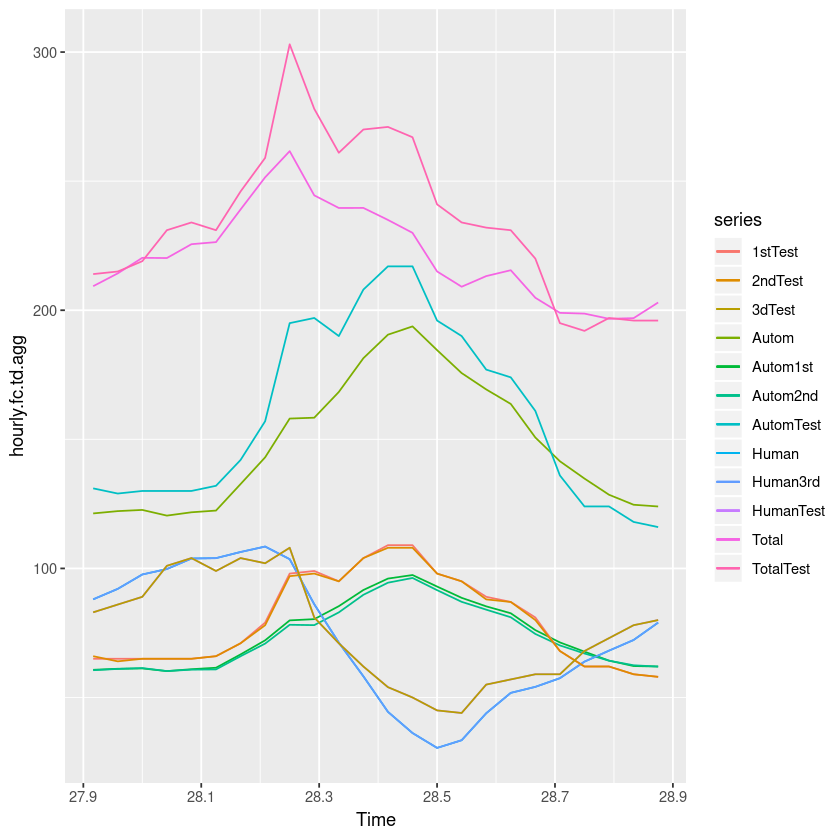

In [275]:
hourly.fc.td.agg <- aggts(hourly.fc.td)
autoplot(hourly.fc.td.agg) +
    autolayer(hourly.test.h.agg, series=c("TotalTest", "AutomTest", "HumanTest", "1stTest", "2ndTest", "3dTest"))

In [277]:
accuracy(hourly.fc.td, hourly.test.h)

,Total,Autom,Human,Autom1st,Autom2nd,Human3rd
ME,13.5060482,11.1131127,2.3929355,5.2282881,5.8848246,2.3929355
RMSE,19.8432927,16.9398162,6.8450770,8.1490690,8.8075660,6.8450770
MAE,15.1660722,14.0695181,5.6374477,6.7737679,7.2957502,5.6374477
MAPE,6.0124817,8.3089284,9.0676984,8.0198058,8.5981574,9.0676984
MPE,5.1645527,5.8976050,5.4710382,5.5078395,6.2874769,5.4710382
MASE,0.5355872,0.6543473,0.3494959,0.6289422,0.6798437,0.3494959


As we can see the results for hourly data is not as good as it is for daily data this is probably due to the fact that the hierarchical structure does not give relevant information for forecasting in this case. One can see that Human3rd (that it is equal to Human) is far better predicted in this case but this does not have anything to do with hierarchical forecastin, this series is easier to forecast by itself as it has been shown [here](./ed_third_floor.ipynb)

## Optimal reconciliation
Optimal forecast reconciliation will happen if we find the matrix $G$ that minimizes the set of coherent forecast generated through $\tilde{y}_h = SG\hat{y}_h$ where $G$ is the matrix that maps the base forecast into the bottom level and the summing-matrix $S$ sums these up using the aggregation structure to produce a set of coherent forecasts $\tilde{y}_h$, $\hat{y}_h$ represents the forecast of all series obtained by ignoring all aggregation constraints. $P = SG$ is called the reconciliation matrix.
For the reconciliation to be optimal we want to minimize the error variances of the coherent forecasts, these error variances are on the diagonal of  $V_h = Var[y_{T + h} - \tilde{y}_h]$ where $W_h = Var[y_{T + h} - \hat{y}_h]$, the optimal reconciled forecast has been shown to be
$
  \tilde{y}_h=S(S'W_h^{-1}S)^{-1}S'W_h^{-1}\hat{y}_h.
$
that is $S$ times optimal $G$. This matrix is pretty hard to calculate so several approximations have been proposed where $W_h$ is calculated weighting easier to calculate matrixes with a scalar weight $k_h$.
In order to use optimal reconciliation one has to specify method="comb" in the forecast function and then the weighting method to be used, in this case the mint method will be used that is the one that makes less simplifying assumptions and the covariance parameter is "sam" that means we will not shrink covariance matrix as often one would do if the difference between bottom width and depth of the hierarchy were significant.

In [87]:
#daily
daily.fc.or <- forecast(daily.train, method="comb", weights="mint", covariance="sam", h=7)

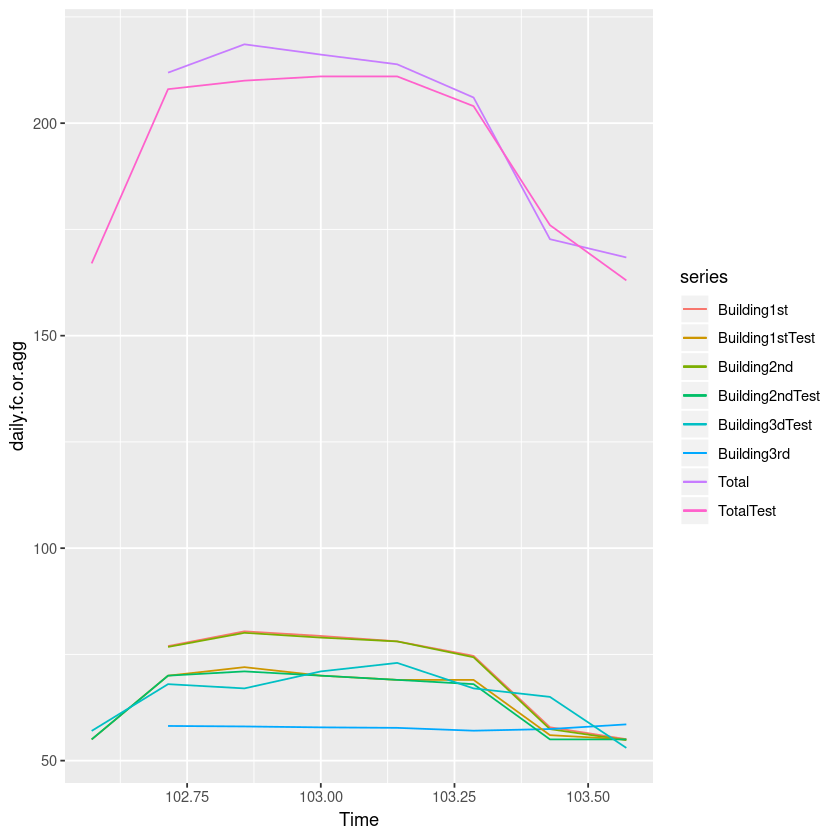

In [88]:
daily.fc.or.agg <- aggts(daily.fc.or)
autoplot(daily.fc.or.agg) +
    autolayer(daily.test.agg, series=c("TotalTest", "Building1stTest", "Building2ndTest", "Building3dTest"))

In [101]:
accuracy(daily.fc.or, daily.test)

,Total,Building1st,Building2nd,Building3rd
ME,-3.5071389,-5.9073733,-6.059479,8.4597138
RMSE,4.8822986,6.8081518,6.930636,10.4927001
MAE,4.4493925,5.9073733,6.109694,10.0410508
MAPE,2.2720962,8.5318189,8.910856,14.8911643
MPE,-1.7367248,-8.5318189,-8.819557,11.9075097
MASE,0.1697323,0.9925401,1.031944,0.5344614


This model gives very low MAPE on the test set, this means that the hierarchical structure adds meaningful information to the set of the series that make it up

In [121]:
hourly.fc.or <- forecast(hourly.train, method="comb", weights="mint", covariance="sam", h=24)

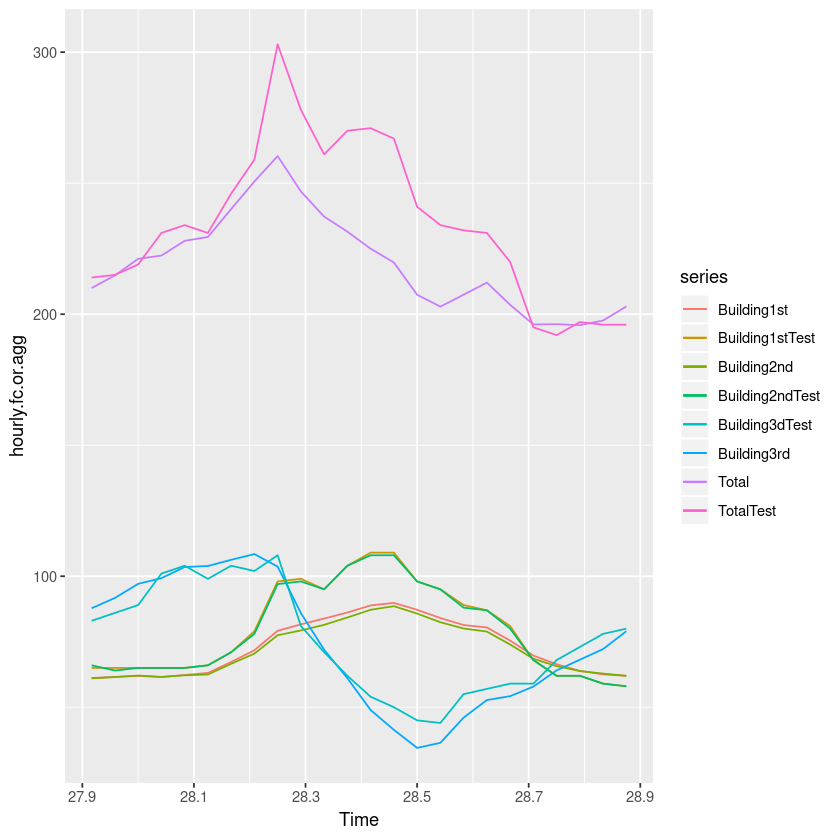

In [122]:
hourly.fc.or.agg <- aggts(hourly.fc.or)
autoplot(hourly.fc.or.agg) +
    autolayer(hourly.test.agg, series=c("TotalTest", "Building1stTest", "Building2ndTest", "Building3dTest"))

In [123]:
accuracy(hourly.fc.or, hourly.test)

,Total,Building1st,Building2nd,Building3rd
ME,15.5679857,6.703338,7.3718573,1.4927907
RMSE,23.1101967,10.053905,10.7693049,5.4155858
MAE,16.9004747,7.995806,8.5243801,4.6663463
MAPE,6.6663253,9.039514,9.6269780,7.1705652
MPE,5.9921089,6.913963,7.7109809,3.6395554
MASE,0.5968373,0.742408,0.7943317,0.2892921


MAPE is not very low and the forecast seems off even just looking at the plot, when this methodology works so bad it usually means that herarchical forecasting is probably not the right choiche, in this case we also saw that third floor hourly data is remarkably hard to forecast so low accuracy results are to be expected.